In [12]:
import fastai
import torch

In [13]:
from fastai.vision import *
import torch.nn.functional as F
from fastai.layers import *

In [44]:
transforms = get_transforms(do_flip=False, max_rotate=5.0, max_zoom=1.0,
    max_warp=0.0) # Todo look at these
DATA_PATH = "C:/Code/Senior Project"
data = ImageDataBunch.from_csv(DATA_PATH, bs=32, size=224, ds_tfms=transforms, label_delim=' ')
                              # ds_tfms=transforms, num_workers=0, bs=32, size=224, csv_labels="labels.csv")

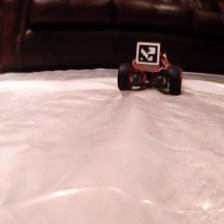

In [64]:
ds = data.valid_ds
img,label = ds[1]
img

In [66]:
print(label)

0.0;0.0


In [55]:
reg_head = torch.nn.Sequential(Flatten(), torch.nn.Linear(25088, 9))
learn = create_cnn(data, models.resnet18, metrics=[], custom_head=reg_head, loss_func=F.mse_loss)

In [56]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (2981 items)
[MultiCategory 0.9;0.0, MultiCategory 0.9;0.0, MultiCategory 0.9;0.0, MultiCategory 0.9;0.0, MultiCategory 0.9;0.0]...
Path: C:\Code\Senior Project
x: ImageItemList (2981 items)
[Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320)]...
Path: C:\Code\Senior Project;

Valid: LabelList
y: MultiCategoryList (745 items)
[MultiCategory 0.8;1.0, MultiCategory 0.0;0.0, MultiCategory 0.0;0.0, MultiCategory 0.85;0.0, MultiCategory 0.0;0.0]...
Path: C:\Code\Senior Project
x: ImageItemList (745 items)
[Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320)]...
Path: C:\Code\Senior Project;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


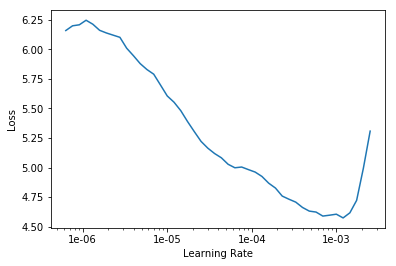

In [58]:
learn.recorder.plot()

In [59]:
epochs = 3
lr = 1e-3 # placeholder 
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss
1,4.066696,3.406649
2,2.344366,1.166385
3,1.074839,0.724189


In [65]:
learn.predict(img)

(MultiCategory -1.0;0.0,
 tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]),
 tensor([-0.6956,  0.8729,  0.8257,  0.0883, -0.5566,  0.3971,  0.1982,  0.2975,
         -0.0267]))